# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [9]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


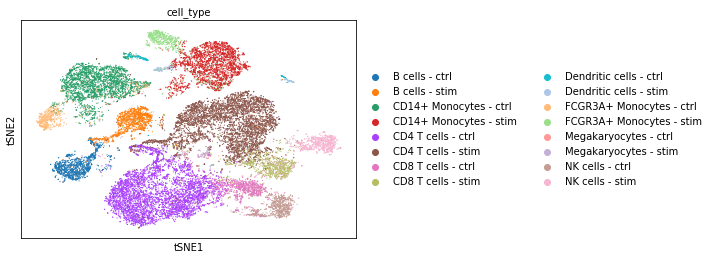

In [13]:
sc.pl.tsne(adata, color='cell_type')

In [14]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [15]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [16]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Plotting functions

In [58]:
def get_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'stim','ind', 'corr'])

def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell','stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'ct','stim','ind', 'corr'])

### Change in correlation in response to IFN-B in all PBMCs

In [18]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata.copy()#adata[adata.obs.cell == 'B cells'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.7)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (24495, 1861)
TF list length 29


In [43]:
%%time
# scmemo.ht_2d_moments(
#     adata_ct, 
#     formula_like='1 + stim', 
#     cov_column='stim', 
#     num_cpus=6, 
#     num_boot=10000)

# adata_ct.write(data_path + 'result_2d/stim_all_pbmc.h5ad')

adata_ct = sc.read(data_path + 'result_2d/stim_all_pbmc.h5ad')
target_genes = adata_ct.var.index.tolist()
available_tfs = adata_ct.uns['scmemo']['2d_moments']['gene_1']

CPU times: user 122 ms, sys: 101 ms, total: 223 ms
Wall time: 222 ms


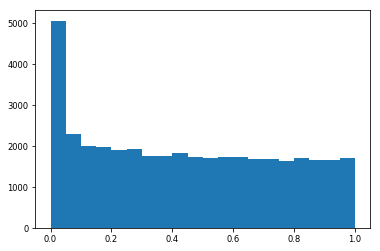

In [39]:
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

In [40]:
mat.shape

(1861, 29)

In [41]:
len(valid_tfs)

22

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

result_df = scmemo.get_2d_ht_result(adata_ct).dropna()

valid_counts = result_df.groupby('gene_1').size()
valid_tfs = valid_counts[valid_counts > 1300].index.tolist()

result_df = result_df.query('gene_1 in @valid_tfs')

mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
mat = np.clip(mat, a_min=-0.6, a_max=.6)

heatmap_df = pd.DataFrame(mat, index=target_genes, columns=available_tfs)[valid_tfs].fillna(0.0)

1240


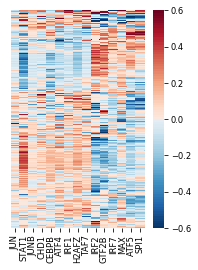

In [45]:
# Draw the heatmap
cg = sns.clustermap(
    heatmap_df[['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']], 
    col_cluster=False
    );
cg.ax_row_dendrogram.set_visible(False)
col_order = ['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']
row_order = cg.dendrogram_row.reordered_ind
plt.close()

select_rows = row_order[:int(len(row_order)/1.5)]
print(len(select_rows))
plt.figure(figsize=(3, 4))
sns.heatmap(heatmap_df[col_order].iloc[select_rows, :], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
# plt.savefig(fig_path + 'tf_heatmap.pdf', bbox_inches='tight')

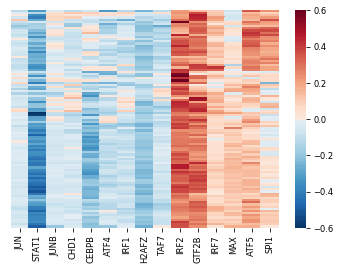

In [75]:
new_heatmap_df = heatmap_df[col_order].iloc[select_rows, :]
sns.heatmap(new_heatmap_df.iloc[200:300], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
genes_1 = new_heatmap_df.iloc[200:300].index.tolist()

In [76]:
print(genes_1)

['DYNLT1', 'GBP5', 'GBP1', 'LAP3', 'MYO1G', 'MBOAT7', 'DDAH2', 'DNAJA1', 'IFI35', 'NAGK', 'WARS', 'SCARB2', 'SNX10', 'OAS1', 'MS4A6A', 'SLC31A2', 'IL4I1', 'PLEK', 'CCRL2', 'C3AR1', 'BST2', 'MGAT1', 'CREG1', 'HPSE', 'CCL2', 'CDKN1A', 'SFT2D1', 'LYN', 'RIT1', 'SHKBP1', 'TNFRSF1A', 'GCLM', 'IRF7', 'TCIRG1', 'ATP6V0D1', 'RNF130', 'AGTRAP', 'GPSM3', 'CYB5R4', 'ATP6V1C1', 'ENY2', 'LACTB', 'GRINA', 'CD48', 'PPP1R15A', 'PLSCR1', 'NAMPT', 'HSBP1', 'GRB2', 'VRK2', 'RAB10', 'PTPRE', 'CCR1', 'NINJ1', 'FNDC3B', 'ATP6V0B', 'CTSZ', 'FTH1', 'PLA2G7', 'CLEC4E', 'S100A10', 'LGALS1', 'FTL', 'ATP6V1F', 'CTSB', 'CFP', 'S100A6', 'GSTO1', 'S100A4', 'C15orf48', 'GRN', 'S100A11', 'LILRB4', 'ANXA2', 'ANXA5', 'CD63', 'KYNU', 'PSAP', 'SOD2', 'SPI1', 'TYROBP', 'CD68', 'FCER1G', 'TYMP', 'BRI3', 'CTSL', 'CSTB', 'LYZ', 'FCGRT', 'SDCBP', 'CTSS', 'CLIC1', 'CFD', 'EMP3', 'DUSP6', 'IGSF6', 'CST3', 'FCN1', 'NPC2', 'GABARAP']


In [ ]:
for gene in genes_1:
    print('---')
    print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format(gene)).sort_values('corr_coef'))

In [57]:
print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef'))

      gene_1 gene_2  corr_coef     corr_pval  corr_fdr
40864  H2AFZ  IL4I1 -0.239784   2.750818e-07  0.000070
20393  STAT1  IL4I1 -0.210088   2.058936e-05  0.001351
18532  IRF1   IL4I1 -0.101022   1.825373e-03  0.056469
25976  JUN    IL4I1 -0.073578   1.556673e-05  0.001055
11088  IRF7   IL4I1  0.168624   3.426383e-03  0.085032
29698  SPI1   IL4I1  0.243244   2.258179e-07  0.000067
22254  GTF2B  IL4I1  0.300408   4.152454e-03  0.096417
35281  ATF5   IL4I1  0.368023   3.340699e-04  0.014433
37142  IRF2   IL4I1  0.445158   4.343105e-03  0.098846


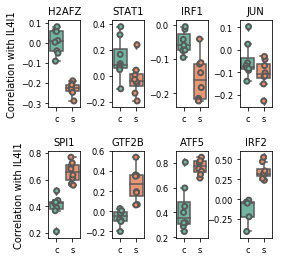

In [58]:
tf_list = df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef').gene_1.tolist()
plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=1, hspace=0.5)

idx = 0
for tf in tf_list:
    
    if tf == 'IRF7':
        continue
        
    plt.subplot(2, 4, idx+1)
    gene_1 = tf
    gene_2 = 'IL4I1'
    
    sns.boxplot(x='stim', y='corr',
                data=get_ind_corr(adata_ct, gene_1, gene_2), 
                palette='Set2')
    sns.stripplot(x='stim', y='corr',
                data=get_ind_corr(adata_ct, gene_1, gene_2), 
                dodge=True, linewidth=2, palette='Set2')
    plt.title(gene_1)
    
    plt.ylabel(''); plt.xlabel('')

    if idx == 0 or idx == 4:
        plt.ylabel('Correlation with {}'.format(gene_2))
    plt.xticks([0, 1], ['c', 's'])
    
    idx += 1
# plt.savefig(fig_path + 'IL4I1_diff_tfs.pdf', bbox_inches='tight')

### CD4 Analysis

In [387]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.8)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (5341, 1877)
TF list length 31


In [388]:
scmemo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=1000)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 159 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 479 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 927 tasks      | elapsed:   20.4s
[Parallel(n_jobs=6)]: Done 1503 tasks      | elapsed:   31.8s
[Parallel(n_jobs=6)]: Done 2207 tasks      | elapsed:   44.1s
[Parallel(n_jobs=6)]: Done 3039 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done 3999 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 5087 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 6303 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 7647 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 9119 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 10719 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 12447 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 14303 tasks      | elapsed:  4.0

In [390]:
# adata_ct.write(data_path + 'result_2d/cM_2d_pooled_tfs.h5ad')
# adata_ct = sc.read(data_path + 'result_2d/Th_2d_pooled_tfs.h5ad')

### CD4/CD14 cells comparison of differential correlation

In [101]:
def get_heatmap_df(adata_ct):
    
    mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
    mat[mat == 0] = np.nan
    mat[mat < -1] = np.nan
    mat[mat > 1] = np.nan

    # mat = np.clip(mat, a_min=-0.6, a_max=0.6)


    means = np.nanmean(mat, axis=0)
    scales = np.nanstd(mat, axis=0)
    mat = (mat - means)/scales
    mat = np.clip(mat, a_min=-1.5, a_max=1.5)
    mat[~np.isfinite(mat)] = 0
    heatmap_df = pd.DataFrame(
        mat, 
        index=adata_ct.uns['scmemo']['2d_moments']['gene_2'], 
        columns=adata_ct.uns['scmemo']['2d_moments']['gene_1']
    ).dropna(0, 'any').fillna(0.0)

    return heatmap_df

In [102]:
adata_Th = adata_ct = sc.read(data_path + 'result_2d/Th_2d_pooled_tfs.h5ad')
adata_cM = adata_ct = sc.read(data_path + 'result_2d/cM_2d_pooled_tfs.h5ad')

In [103]:
target_overlap = list(set(adata_Th.uns['scmemo']['2d_moments']['gene_2']) & set(adata_cM.uns['scmemo']['2d_moments']['gene_2']))
tf_overlap = list(set(adata_Th.uns['scmemo']['2d_moments']['gene_1']) & set(adata_cM.uns['scmemo']['2d_moments']['gene_1']))


In [104]:
heatmap_df_Th = get_heatmap_df(adata_Th)[tf_overlap]#.loc[target_overlap]
heatmap_df_Th.columns = heatmap_df_Th.columns + '_Th'

heatmap_df_cM = get_heatmap_df(adata_cM)[tf_overlap]#.loc[target_overlap]
heatmap_df_cM.columns = heatmap_df_cM.columns + '_cM'

heatmap_df_all = pd.concat([heatmap_df_Th, heatmap_df_cM], axis=1)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [105]:
heatmap_df_all.shape

(2366, 38)

In [127]:
result_df_Th = scmemo.get_2d_ht_result(adata_Th)#.dropna()
result_df_cM = scmemo.get_2d_ht_result(adata_cM)#.dropna()

result_df = result_df_Th#pd.concat([result_df_Th, result_df_cM])

sig_df = result_df.sort_values('corr_coef').query('corr_fdr < 0.1')
sig_tf = sig_df.gene_1.drop_duplicates().tolist()
sig_tf = list(set(sig_tf) & set(tf_overlap))
sig_target = list(set(sig_df.gene_2.drop_duplicates().tolist()) & set(target_overlap))

sig_target = [tf for tf in sig_target if 'RP' != tf[:2]]

In [128]:
len(sig_tf)

18

In [129]:
heatmap_df_all.shape

(2366, 38)

In [130]:
len(row_order)

132

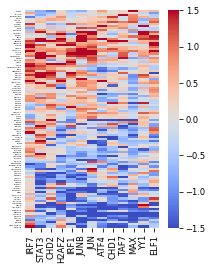

In [196]:
cg = sns.clustermap(
    heatmap_df_Th.loc[sig_target],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
#     metric='cosine'
    );
cg.ax_row_dendrogram.set_visible(False)
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
selected_rows = list(range(35, 65)) + list(range(100, 132))
# plt.close()
# cg = sns.clustermap(
#     heatmap_df_Th.loc[sig_target].iloc[selected_rows, col_order],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
#     cmap='coolwarm',
#     row_cluster=False,
#     col_cluster=False,
# #     metric='cosine'
#     );
plt.close()


plt.figure(figsize=(3, 4))
to_drop = ['CBX3_Th','NELFE_Th', 'NR3C1_Th', 'NCOR1_Th', 'GTF2B_Th', 'CEBPB_Th']
temp = heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order]
temp = temp[[col for col in temp.columns if col not in to_drop]]
temp.columns = temp.columns.map(lambda x: x.split('_')[0])
sns.heatmap(temp, cmap='coolwarm')
plt.yticks(np.arange(temp.shape[0])+0.5, temp.index, fontsize=2.4);
plt.tick_params(axis='y', length = 0)
plt.savefig('temp.pdf')
plt.savefig(fig_path + 'cd4_tf_stim_corrs.pdf', bbox_inches='tight')


In [152]:
for gene in heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order].index[10:50]:
    print(result_df.query('gene_2 == "{}"'.format(gene)).query('corr_fdr < 0.1'))

      gene_1  gene_2  corr_coef     corr_pval  corr_fdr
13270  NR3C1  ARID5A -0.311404   4.550345e-05  0.016284
23038  GATA3  ARID5A  0.275710   3.226685e-05  0.013375
29550  JUNB   ARID5A  0.309293   9.278842e-07  0.001673
39318  YY1    ARID5A  0.435190   7.792442e-05  0.023411
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
48721  JUN    TPM4   0.266953   0.000006   0.005495
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
30215  JUNB   IRF7   0.182206   0.00001    0.007185
      gene_1   gene_2  corr_coef  corr_pval  corr_fdr
16641  ATF4   ARL6IP5  0.513776   0.000109   0.030103
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
29809  JUNB   UBE2B  0.254604   0.000063   0.019588
      gene_1  gene_2  corr_coef  corr_pval  corr_fdr
35129  ELF1   UBE2L6  0.398258   0.000016   0.009097
     gene_1 gene_2  corr_coef  corr_pval  corr_fdr
7625  H2AFZ  SAP18  0.44892    0.000174   0.04422 
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
9769   IRF7   ISG15  0.413001   0.000254

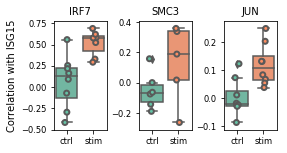

In [199]:
gene = 'ISG15'
tfs = ['IRF7', 'SMC3', 'JUN']
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.6)

for idx, tf in enumerate(tfs):
    plt.subplot(1, 3, idx+1)
    plot_df = get_ct_ind_corr(adata, tf, gene).query('corr < 1 & corr > -1').query('ct == "Th"')
    sns.boxplot(x='stim', y='corr', data=plot_df, palette='Set2')
    sns.stripplot(x='stim', y='corr', dodge=True, data=plot_df, linewidth=2, palette='Set2')
    plt.xlabel(None)
    plt.title(tf)
    if idx == 0:
        plt.ylabel('Correlation with ISG15')
    else:
        plt.ylabel(None)
plt.savefig(fig_path + 'cd4_ISG15_dc.pdf', bbox_inches='tight')


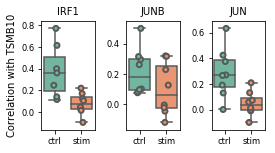

In [200]:
gene = 'TMSB10'
tfs = ['IRF1', 'JUNB', 'JUN']
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.6)

for idx, tf in enumerate(tfs):
    plt.subplot(1, 3, idx+1)
    plot_df = get_ct_ind_corr(adata, tf, gene).query('corr < 1 & corr > -1').query('ct == "Th"')
    sns.boxplot(x='stim', y='corr', data=plot_df, palette='Set2')
    sns.stripplot(x='stim', y='corr', dodge=True, data=plot_df, linewidth=2, palette='Set2')
    plt.xlabel(None)
    plt.title(tf)
    if idx == 0:
        plt.ylabel('Correlation with TSMB10')
    else:
        plt.ylabel(None)
        
plt.savefig(fig_path + 'cd4_TSMB10_dc.pdf', bbox_inches='tight')
